In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# **X-ray Chest Classification**

## **Deep Learning Model for Chest X-ray Classification**

This notebook implements a convolutional neural network (CNN) to classify chest X-ray images into three categories:
- Normal
- COVID-19
- Pneumonia

**Dataset Source**: [COVID Pneumonia Normal Chest X-ray Images](https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
from utils import train_one_epoch, evaluate, get_device, set_seed, save_experiment_json, plot_history, performance, save_checkpoint, EarlyStopping
import torchsummary
set_seed(42)

In [4]:
CLASSES = ['COVID', 'NORMAL', 'PNEUMONIA']


In [5]:
project_root = os.getcwd()
BASE_DIR = os.path.basename(project_root)
DEVICE = get_device()
print("base dir:", BASE_DIR)
print('  device:', DEVICE)

base dir: xray_chest_classification
  device: mps


# 1. **Dataset Loading**

In [6]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for class_name in CLASSES:
            class_path = os.path.join(data_dir, class_name)
            for image in os.listdir(class_path):
                self.images.append(os.path.join(class_path, image))
                self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        img = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        y = CLASSES.index(label)
        transformed_image = self.transform(img)
        original_image = torch.tensor(cv2.resize(np.asarray(img), (224, 224)))

        return original_image, transformed_image, torch.tensor(y)

In [7]:
train_dir = os.path.join(project_root,"data/train")
val_dir = os.path.join(project_root,"data/val")
test_dir = os.path.join(project_root,"data/test")

BATCH_SIZE = 32

train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

eval_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_dataset = ChestXrayDataset(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

val_dataset = ChestXrayDataset(val_dir, transform=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True  )

test_dataset = ChestXrayDataset(test_dir,transform=eval_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print("Train loader size: ", len(train_loader))
print("Train loader size: ", len(val_loader))
print("Train loader size: ", len(test_loader))

Train loader size:  115
Train loader size:  25
Train loader size:  25


In [8]:
original_img, inputs, labels = next(iter(train_loader))

/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


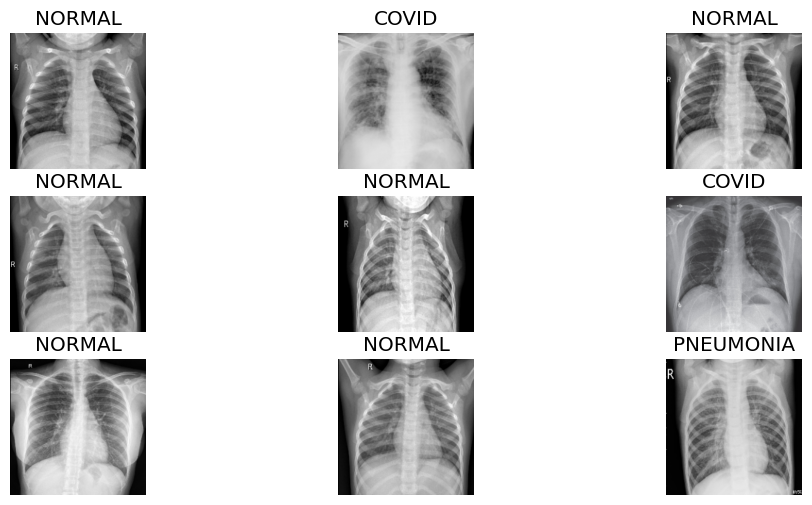

In [9]:
plt.figure(figsize=(12, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(
        original_img[i].cpu().detach().numpy().reshape(224, 224, 3).astype("uint8")
    )
    plt.title(f"{CLASSES[labels[i]]}")
    plt.axis("off")

# **2. Baseline Model**

In [10]:
from model import BaselineCNN
baseline_model = BaselineCNN(num_classes=len(CLASSES))
torchsummary.summary(baseline_model, (3, 224, 224), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 224, 224]             896
              ReLU-2         [32, 32, 224, 224]               0
         MaxPool2d-3         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-4             [32, 32, 4, 4]               0
           Flatten-5                  [32, 512]               0
            Linear-6                    [32, 3]           1,539
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 18.38
Forward/backward pass size (MB): 882.25
Params size (MB): 0.01
Estimated Total Size (MB): 900.64
----------------------------------------------------------------


In [11]:
NUM_EPOCHS = 30
LR = 1e-3
PATIENCE = 5
MODEL_NAME = "BaselineModel"

In [12]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

In [13]:
baseline_model = baseline_model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=baseline_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [14]:
MODEL_SAVED_PATH = f"{project_root}/model_checkpoints/best_{MODEL_NAME}.pth"
history['MODEL_SAVED_PATH'] = MODEL_SAVED_PATH
early_stopping = EarlyStopping(
    model_checkpoint=MODEL_SAVED_PATH, patience=PATIENCE, mode='min')

In [15]:
for epoch in range(NUM_EPOCHS):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(baseline_model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc = evaluate(baseline_model, val_loader, criterion, DEVICE)

    print(f"[{epoch + 1}/{NUM_EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")

    # Metrics record
    history['train_losses'].append(train_loss)
    history['val_losses'].append(valid_loss)
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(valid_acc)

    should_stop, best_score, best_epoch = early_stopping.should_stop(
        baseline_model, optimizer=optimizer, epoch=epoch, score=valid_loss)
    if should_stop:
        print(f"[Early Stopping]: Stop at epoch {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}")
        break
    history['best_epoch'] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['val_accuracy'][best_epoch - 1]:.4f}\n"
    )

Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.68it/s]


[1/30] train_acc: 0.5860 - train_loss: 0.8917 - valid_acc: 0.6411 - valid_loss: 0.7060
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 1 - acc: 0.6411



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.94it/s]


[2/30] train_acc: 0.6335 - train_loss: 0.8132 - valid_acc: 0.7331 - valid_loss: 0.6352
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 2 - acc: 0.7331



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


[3/30] train_acc: 0.6529 - train_loss: 0.7968 - valid_acc: 0.7356 - valid_loss: 0.6324
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 3 - acc: 0.7356



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  8.25it/s]


[4/30] train_acc: 0.6715 - train_loss: 0.7674 - valid_acc: 0.7995 - valid_loss: 0.5757
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 4 - acc: 0.7995



Evaluating: 100%|██████████| 25/25 [00:02<00:00,  8.48it/s]


[5/30] train_acc: 0.6912 - train_loss: 0.7483 - valid_acc: 0.8097 - valid_loss: 0.5714
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 5 - acc: 0.8097



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 11.77it/s]


[6/30] train_acc: 0.6860 - train_loss: 0.7470 - valid_acc: 0.8110 - valid_loss: 0.5345
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 6 - acc: 0.8110



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 13.04it/s]


[7/30] train_acc: 0.6865 - train_loss: 0.7518 - valid_acc: 0.7829 - valid_loss: 0.5549
	- [current best] epoch: 6 - acc: 0.8110



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 13.14it/s]


[8/30] train_acc: 0.6972 - train_loss: 0.7249 - valid_acc: 0.7995 - valid_loss: 0.5314
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 8 - acc: 0.7995



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


[9/30] train_acc: 0.6996 - train_loss: 0.7315 - valid_acc: 0.8391 - valid_loss: 0.5191
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 9 - acc: 0.8391



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.63it/s]


[10/30] train_acc: 0.7160 - train_loss: 0.6984 - valid_acc: 0.8161 - valid_loss: 0.5075
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 10 - acc: 0.8161



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


[11/30] train_acc: 0.7204 - train_loss: 0.6936 - valid_acc: 0.8135 - valid_loss: 0.5025
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 11 - acc: 0.8135



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 12.34it/s]


[12/30] train_acc: 0.7182 - train_loss: 0.7025 - valid_acc: 0.8238 - valid_loss: 0.4904
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 12 - acc: 0.8238



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 13.05it/s]


[13/30] train_acc: 0.7292 - train_loss: 0.6843 - valid_acc: 0.8378 - valid_loss: 0.4759
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 13 - acc: 0.8378



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 13.14it/s]


[14/30] train_acc: 0.7270 - train_loss: 0.6866 - valid_acc: 0.8493 - valid_loss: 0.4593
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 14 - acc: 0.8493



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 13.10it/s]


[15/30] train_acc: 0.7393 - train_loss: 0.6662 - valid_acc: 0.6003 - valid_loss: 0.8434
	- [current best] epoch: 14 - acc: 0.8493



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 13.62it/s]


[16/30] train_acc: 0.7218 - train_loss: 0.6956 - valid_acc: 0.8493 - valid_loss: 0.4592
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 16 - acc: 0.8493



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 13.76it/s]


[17/30] train_acc: 0.7354 - train_loss: 0.6706 - valid_acc: 0.7752 - valid_loss: 0.5488
	- [current best] epoch: 16 - acc: 0.8493



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 12.71it/s]


[18/30] train_acc: 0.7423 - train_loss: 0.6436 - valid_acc: 0.8352 - valid_loss: 0.4663
	- [current best] epoch: 16 - acc: 0.8493



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 13.36it/s]


[19/30] train_acc: 0.7423 - train_loss: 0.6424 - valid_acc: 0.8570 - valid_loss: 0.4413
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 19 - acc: 0.8570



Evaluating: 100%|██████████| 25/25 [00:01<00:00, 13.05it/s]


[20/30] train_acc: 0.7554 - train_loss: 0.6263 - valid_acc: 0.8697 - valid_loss: 0.4096
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_BaselineModel.pth
	- [current best] epoch: 20 - acc: 0.8697



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 12.30it/s]


[21/30] train_acc: 0.7527 - train_loss: 0.6364 - valid_acc: 0.8404 - valid_loss: 0.4659
	- [current best] epoch: 20 - acc: 0.8697



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


[22/30] train_acc: 0.7581 - train_loss: 0.6281 - valid_acc: 0.8531 - valid_loss: 0.4458
	- [current best] epoch: 20 - acc: 0.8697



Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


[23/30] train_acc: 0.7584 - train_loss: 0.6267 - valid_acc: 0.8033 - valid_loss: 0.5235
	- [current best] epoch: 20 - acc: 0.8697



Evaluating: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


[24/30] train_acc: 0.7532 - train_loss: 0.6390 - valid_acc: 0.8672 - valid_loss: 0.4215
	- [current best] epoch: 20 - acc: 0.8697



Evaluating: 100%|██████████| 25/25 [00:02<00:00,  8.74it/s]

[25/30] train_acc: 0.7625 - train_loss: 0.6291 - valid_acc: 0.8736 - valid_loss: 0.4164
[Early Stopping]: Stop at epoch 25 - Best epoch: 20 - Best score: 0.4096159417358243


In [16]:
MODEL_SAVED = f"{project_root}/model_checkpoints/{MODEL_NAME}_model_weights.pth"
save_checkpoint(baseline_model, optimizer, MODEL_SAVED)

Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/BaselineModel_model_weights.pth


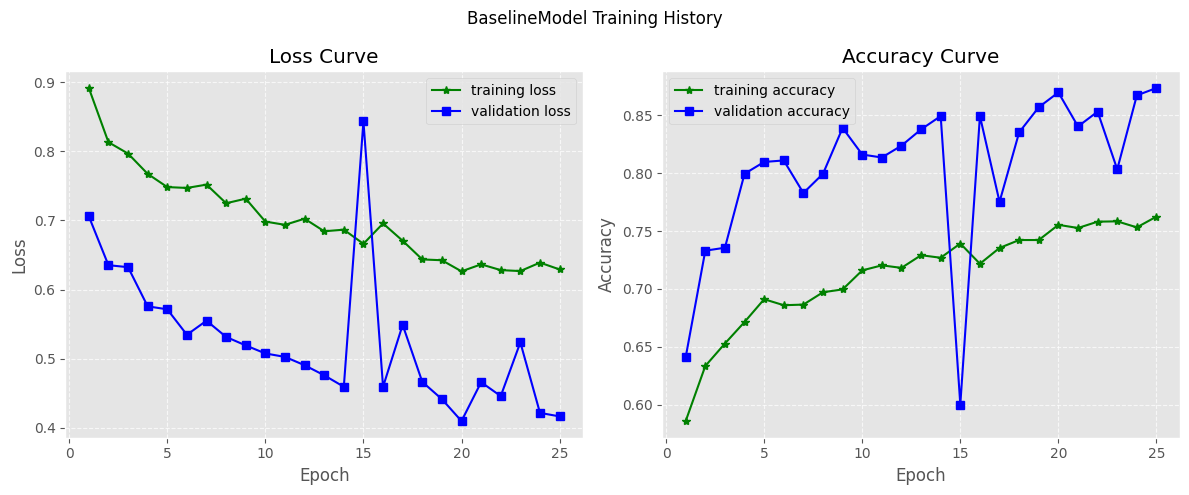

In [17]:
SAVE_PATH = f"{project_root}/results/{MODEL_NAME}"
plot_history(
    history,
    title=f"{MODEL_NAME} Training History",
    save_path=f"{SAVE_PATH}.png")

Getting predictions: 100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Accuracy score: 0.8473
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       245
           1       0.76      0.97      0.85       271
           2       0.91      0.73      0.81       270

    accuracy                           0.85       786
   macro avg       0.87      0.85      0.85       786
weighted avg       0.86      0.85      0.85       786



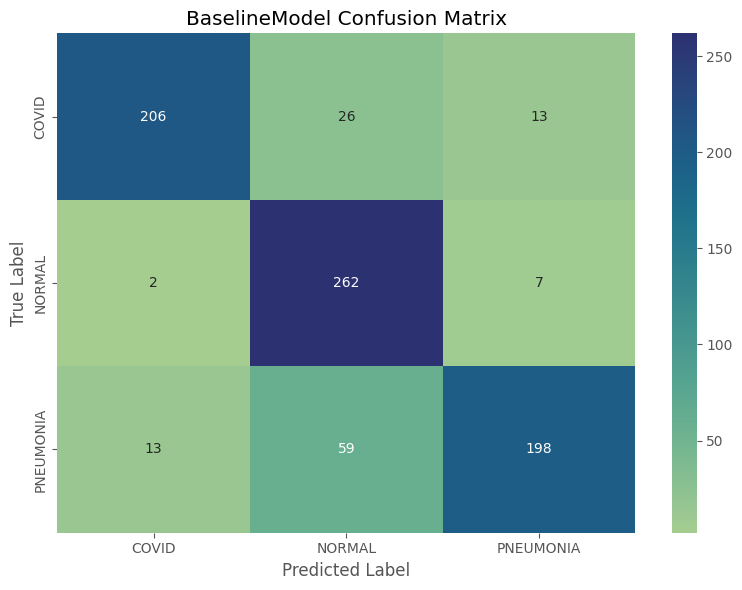

In [18]:
SAVE_PATH = f"{project_root}/results/{MODEL_NAME}_cfm.png"
performance(baseline_model, test_loader, DEVICE, MODEL_NAME, class_names=CLASSES, save_path=SAVE_PATH)

# **3. Reference Model: EfficientNet (Transfer Learning)**



In [19]:
from model import SimpleEfficientNet

In [20]:
EPOCHS_STAGE_1 = 10  
LR_STAGE_1 = 1e-3  
EPOCHS_STAGE_2 = 20  
LR_STAGE_2 = 1e-5  
MODEL_NAME = "SimpleEfficientNet"

In [21]:
model = SimpleEfficientNet(num_classes=len(CLASSES))
torchsummary.summary(model, (3, 224, 224), batch_size=32)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [22]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

### 3.1 Train head-only

In [23]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_1)
criterion = nn.CrossEntropyLoss()

In [24]:
MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}.pth")
f"{project_root}/model_checkpoints/{MODEL_NAME}.pth"
history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH
early_stopping = EarlyStopping(model_checkpoint=MODEL_SAVED_PATH, patience=PATIENCE, mode="min")

In [25]:
print(
    f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}"
)

for epoch in range(EPOCHS_STAGE_1):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, DEVICE)

    print(f"[{epoch + 1}/{NUM_EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")

    # Metrics record
    history['train_losses'].append(train_loss)
    history['val_losses'].append(valid_loss)
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(valid_acc)

    should_stop, best_score, best_epoch = early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_loss)
    if should_stop:
        print(f"[Early Stopping]: Stop at epoch {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}")
        break
    history['best_epoch'] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['val_accuracy'][best_epoch - 1]:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Training:   0%|          | 0/115 [00:00<?, ?it/s]/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 25/25 [00:04<00:00,  5.77it/s]


[1/30] train_acc: 0.8019 - train_loss: 0.5765 - valid_acc: 0.9208 - valid_loss: 0.2989
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 1 - acc: 0.9208



Evaluating: 100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


[2/30] train_acc: 0.8595 - train_loss: 0.3940 - valid_acc: 0.9259 - valid_loss: 0.2520
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 2 - acc: 0.9259



Evaluating: 100%|██████████| 25/25 [00:04<00:00,  6.03it/s]


[3/30] train_acc: 0.8669 - train_loss: 0.3661 - valid_acc: 0.9298 - valid_loss: 0.2365
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 3 - acc: 0.9298



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


[4/30] train_acc: 0.8784 - train_loss: 0.3374 - valid_acc: 0.9246 - valid_loss: 0.2317
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 4 - acc: 0.9246



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  6.25it/s]


[5/30] train_acc: 0.8797 - train_loss: 0.3207 - valid_acc: 0.9285 - valid_loss: 0.2327
	- [current best] epoch: 4 - acc: 0.9246



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


[6/30] train_acc: 0.8877 - train_loss: 0.3162 - valid_acc: 0.9272 - valid_loss: 0.2280
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 6 - acc: 0.9272



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


[7/30] train_acc: 0.8882 - train_loss: 0.3047 - valid_acc: 0.9298 - valid_loss: 0.2161
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 7 - acc: 0.9298



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


[8/30] train_acc: 0.8923 - train_loss: 0.2947 - valid_acc: 0.9285 - valid_loss: 0.2282
	- [current best] epoch: 7 - acc: 0.9298



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  8.07it/s]


[9/30] train_acc: 0.8849 - train_loss: 0.2977 - valid_acc: 0.9298 - valid_loss: 0.2246
	- [current best] epoch: 7 - acc: 0.9298



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.70it/s]


[10/30] train_acc: 0.8866 - train_loss: 0.2860 - valid_acc: 0.9259 - valid_loss: 0.2057
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/SimpleEfficientNet.pth
	- [current best] epoch: 10 - acc: 0.9259



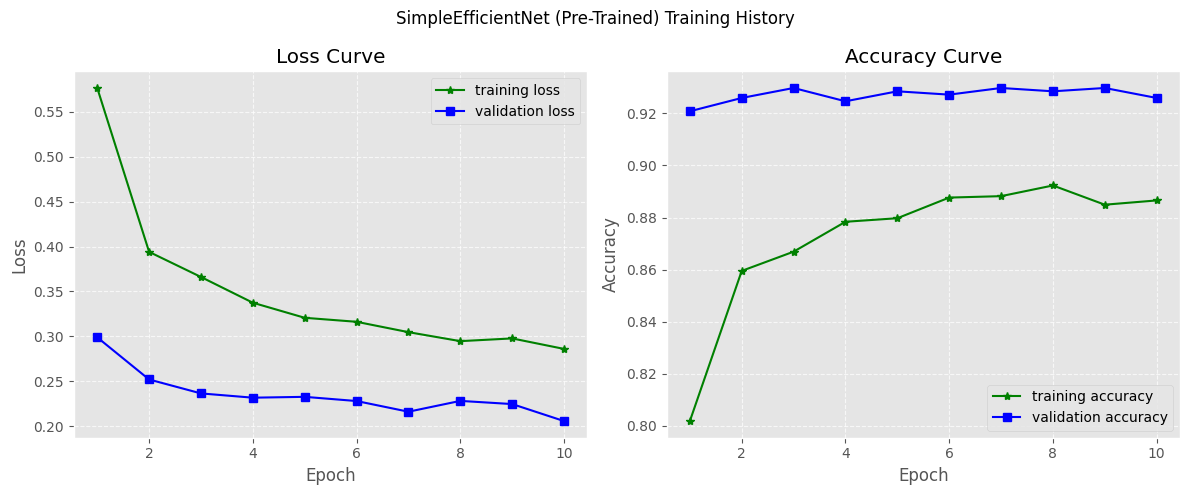

In [26]:
plot_history(history, f"{MODEL_NAME} (Pre-Trained) Training History")

In [27]:
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 25/25 [00:03<00:00,  6.94it/s]

Accuracy score: 0.9211
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       245
           1       0.91      0.89      0.90       271
           2       0.90      0.92      0.91       270

    accuracy                           0.92       786
   macro avg       0.92      0.92      0.92       786
weighted avg       0.92      0.92      0.92       786



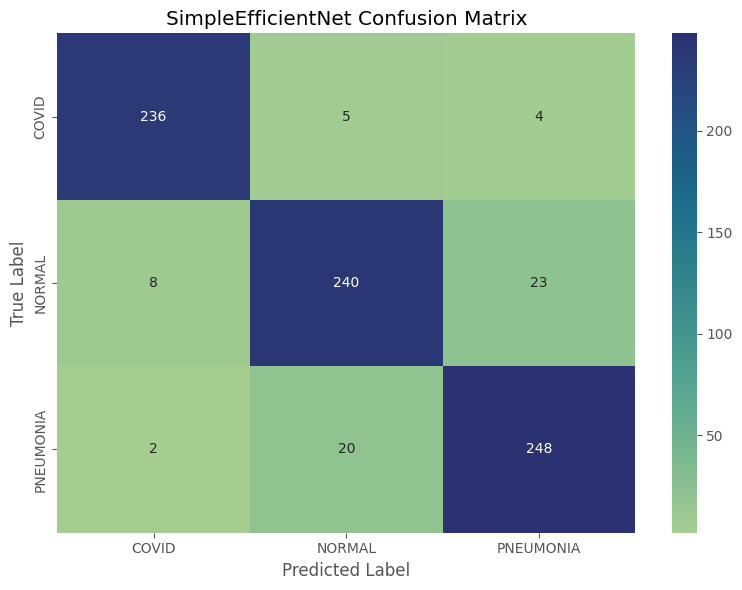

In [28]:
save_path = f"{project_root}/results/{MODEL_NAME}_cfm.png"
performance(model, test_loader, DEVICE, MODEL_NAME,class_names=CLASSES, save_path=save_path)

In [29]:
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_history.json",
)
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/results/SimpleEfficientNet_history.json


## **3.2. Fine-Tuning**

In [30]:
params = list(model.parameters())
print("Number of layers: ", len(params))

Number of layers:  213


In [31]:
num_unfreezed_layers = 50
features_param = list(model.model.features)
for param in features_param[-num_unfreezed_layers:]:
    param.requires_grad = True
torchsummary.summary(model.to('cpu'), (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [32]:
model = model.to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_2)
criterion = nn.CrossEntropyLoss()
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_finetuned.pth"
new_early_stopping = EarlyStopping(model_checkpoint=model_save_path, patience=PATIENCE, mode = 'min')

In [33]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2


print(
    f"Training configuration for stage 2: LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}"
)
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )

    should_stop, best_score, best_epoch = new_early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_loss
    )
    if should_stop:
        print(
            f"Early stopping: Stop at epoch: {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}"
        )
        break

    if should_stop:
        print(f"[Early Stopping]: Stop at epoch {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}")
        break
    history['best_epoch'] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['val_accuracy'][best_epoch - 1]:.4f}\n"
    )

Training configuration for stage 2: LR = 1e-05, EPOCHS = 20


Training:   0%|          | 0/115 [00:00<?, ?it/s]/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


[11/30 (Fine-Tune)] train_acc: 0.8904 - train_loss: 0.2978 - valid_acc: 0.9208 - valid_loss: 0.2155
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_SimpleEfficientNet_finetuned.pth
	- [current best] epoch: 11 - acc: 0.9208



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


[12/30 (Fine-Tune)] train_acc: 0.8959 - train_loss: 0.2839 - valid_acc: 0.9259 - valid_loss: 0.2161
	- [current best] epoch: 11 - acc: 0.9208



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


[13/30 (Fine-Tune)] train_acc: 0.9005 - train_loss: 0.2714 - valid_acc: 0.9310 - valid_loss: 0.2005
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_SimpleEfficientNet_finetuned.pth
	- [current best] epoch: 13 - acc: 0.9310



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


[14/30 (Fine-Tune)] train_acc: 0.9011 - train_loss: 0.2824 - valid_acc: 0.9272 - valid_loss: 0.2172
	- [current best] epoch: 13 - acc: 0.9310



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  8.19it/s]


[15/30 (Fine-Tune)] train_acc: 0.8920 - train_loss: 0.2935 - valid_acc: 0.9246 - valid_loss: 0.2025
	- [current best] epoch: 13 - acc: 0.9310



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  8.19it/s]


[16/30 (Fine-Tune)] train_acc: 0.8904 - train_loss: 0.2919 - valid_acc: 0.9336 - valid_loss: 0.2070
	- [current best] epoch: 13 - acc: 0.9310



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  8.14it/s]


[17/30 (Fine-Tune)] train_acc: 0.8981 - train_loss: 0.2825 - valid_acc: 0.9285 - valid_loss: 0.2071
	- [current best] epoch: 13 - acc: 0.9310



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.70it/s]

[18/30 (Fine-Tune)] train_acc: 0.8940 - train_loss: 0.2816 - valid_acc: 0.9323 - valid_loss: 0.2225
Early stopping: Stop at epoch: 18 - Best epoch: 13 - Best score: 0.20046801218051716


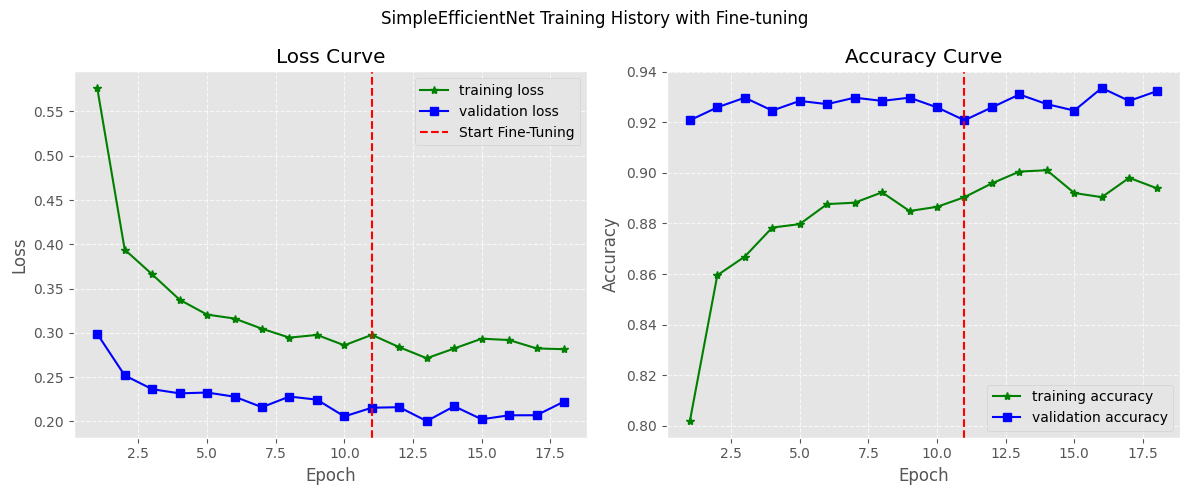

In [34]:
model_saved_name = (
    f"{project_root}/results/{MODEL_NAME}_finetuned"
)
plot_history(
    history,
    f"{MODEL_NAME} Training History with Fine-tuning",
    f"{model_saved_name}.png",
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1,
)

In [35]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s]

Accuracy score: 0.9249
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       245
           1       0.92      0.89      0.90       271
           2       0.90      0.92      0.91       270

    accuracy                           0.92       786
   macro avg       0.93      0.93      0.93       786
weighted avg       0.92      0.92      0.92       786



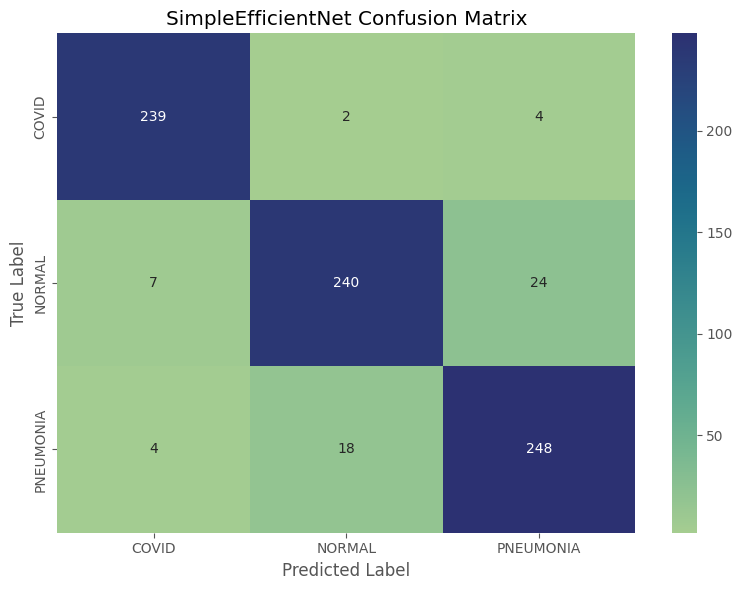

In [36]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_finetuned_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME, class_names=CLASSES, save_path=save_path)

In [37]:
history["MODEL_SAVED_PATH"] = model_save_path
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_finetuned_history.json",
)
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/results/SimpleEfficientNet_finetuned_history.json


# **4. Advanced Model (Modified EfficientNet for Model Improvement)**

In [38]:
EPOCHS_STAGE_1 = 10  
LR_STAGE_1 = 1e-3  
EPOCHS_STAGE_2 = 20  
LR_STAGE_2 = 1e-5  
PATIENCE = 5
MODEL_NAME = "EfficientNetAdvanced"

In [39]:
from model import EfficientAdvanced

In [41]:
model = EfficientAdvanced(num_classes=len(CLASSES))
torchsummary.summary(model, (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [61]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

### **4.1 Train Head-only first**

In [62]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_1)
criterion = nn.CrossEntropyLoss()
MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}.pth"
)
history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH
early_stopping = EarlyStopping(
    model_checkpoint=MODEL_SAVED_PATH, patience=PATIENCE, mode="min"
)

In [63]:
print(
    f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}"
)

for epoch in range(EPOCHS_STAGE_1):
    # # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)

    should_stop, best_score, best_epoch = early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_loss
    )
    if should_stop:
        print(f"[Early Stopping]: Stop at epoch {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}")
        break
    history['best_epoch'] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['val_accuracy'][best_epoch - 1]:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Training:   0%|          | 0/115 [00:00<?, ?it/s]

/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


[1/10] train_acc: 0.8759 - train_loss: 0.3215 - valid_acc: 0.9221 - valid_loss: 0.2257
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 1 - acc: 0.9221



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


[2/10] train_acc: 0.8781 - train_loss: 0.3259 - valid_acc: 0.9221 - valid_loss: 0.2247
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 2 - acc: 0.9221



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


[3/10] train_acc: 0.8828 - train_loss: 0.3113 - valid_acc: 0.9246 - valid_loss: 0.2501
	- [current best] epoch: 2 - acc: 0.9221



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.74it/s]


[4/10] train_acc: 0.8822 - train_loss: 0.3110 - valid_acc: 0.9259 - valid_loss: 0.2246
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 4 - acc: 0.9259



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.56it/s]


[5/10] train_acc: 0.8877 - train_loss: 0.2997 - valid_acc: 0.9349 - valid_loss: 0.2255
	- [current best] epoch: 4 - acc: 0.9259



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.70it/s]


[6/10] train_acc: 0.8860 - train_loss: 0.2996 - valid_acc: 0.9285 - valid_loss: 0.2198
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 6 - acc: 0.9285



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.55it/s]


[7/10] train_acc: 0.8926 - train_loss: 0.2901 - valid_acc: 0.9310 - valid_loss: 0.2353
	- [current best] epoch: 6 - acc: 0.9285



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


[8/10] train_acc: 0.8975 - train_loss: 0.2831 - valid_acc: 0.9349 - valid_loss: 0.2289
	- [current best] epoch: 6 - acc: 0.9285



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.74it/s]


[9/10] train_acc: 0.8882 - train_loss: 0.3013 - valid_acc: 0.9259 - valid_loss: 0.2167
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 9 - acc: 0.9259



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.61it/s]

[10/10] train_acc: 0.8915 - train_loss: 0.3000 - valid_acc: 0.9298 - valid_loss: 0.2063
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 10 - acc: 0.9298



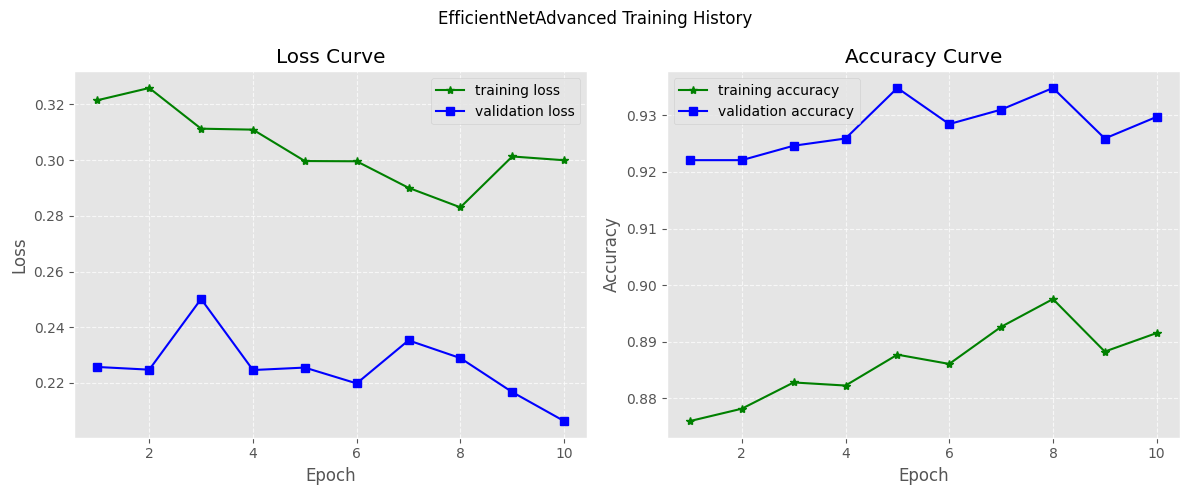

In [64]:
plot_history(history, f"{MODEL_NAME} Training History")

In [65]:
# Load the model again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 25/25 [00:03<00:00,  7.68it/s]

Accuracy score: 0.9148
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       245
           1       0.89      0.87      0.88       271
           2       0.92      0.90      0.91       270

    accuracy                           0.91       786
   macro avg       0.91      0.92      0.92       786
weighted avg       0.91      0.91      0.91       786



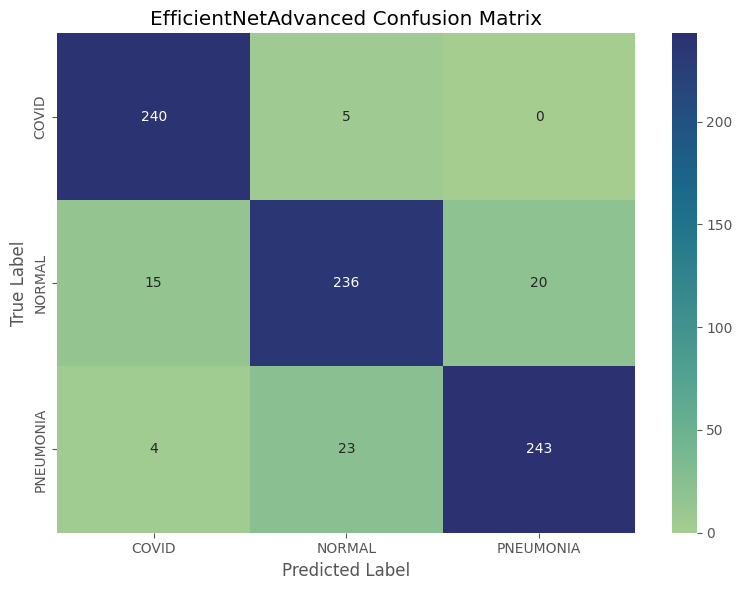

In [66]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME,class_names=CLASSES, save_path=save_path)

In [67]:
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_history.json",
)
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/results/EfficientNetAdvanced_history.json


## **4.2 Fine-tune the Model by Unfreezing Some Layers**

In [68]:
params = list(model.parameters())
print("Number of layers: ", len(params))

Number of layers:  217


In [69]:
num_unfreezed_layers = 54
features_param = list(model.model.features)
for param in features_param[-num_unfreezed_layers:]:
    param.requires_grad = True
torchsummary.summary(model.to('cpu'), (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [70]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_2)
criterion = nn.CrossEntropyLoss()
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_finetuned.pth"
new_early_stopping = EarlyStopping(model_checkpoint=model_save_path, patience=PATIENCE, mode = 'min')

In [71]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2


print(
    f"Training configuration for stage 2: LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}"
)
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, DEVICE)
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )

    should_stop, best_score, best_epoch = new_early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_loss
    )
    if should_stop:
        print(
            f"Early stopping: Stop at epoch: {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}"
        )
        break

    if should_stop:
        print(
            f"[Early Stopping]: Stop at epoch {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}"
        )
        break
    history["best_epoch"] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['val_accuracy'][best_epoch - 1]:.4f}\n"
    )

Training configuration for stage 2: LR = 1e-05, EPOCHS = 20


Training:   0%|          | 0/115 [00:00<?, ?it/s]/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


[11/30 (Fine-Tune)] train_acc: 0.9013 - train_loss: 0.2778 - valid_acc: 0.9310 - valid_loss: 0.2066
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_EfficientNetAdvanced_finetuned.pth
	- [current best] epoch: 11 - acc: 0.9310



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s]


[12/30 (Fine-Tune)] train_acc: 0.8964 - train_loss: 0.2832 - valid_acc: 0.9285 - valid_loss: 0.2150
	- [current best] epoch: 11 - acc: 0.9310



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.58it/s]


[13/30 (Fine-Tune)] train_acc: 0.8866 - train_loss: 0.3087 - valid_acc: 0.9285 - valid_loss: 0.2066
	- [current best] epoch: 11 - acc: 0.9310



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.87it/s]


[14/30 (Fine-Tune)] train_acc: 0.8994 - train_loss: 0.2724 - valid_acc: 0.9336 - valid_loss: 0.2028
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_EfficientNetAdvanced_finetuned.pth
	- [current best] epoch: 14 - acc: 0.9336



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.69it/s]


[15/30 (Fine-Tune)] train_acc: 0.9008 - train_loss: 0.2718 - valid_acc: 0.9349 - valid_loss: 0.1925
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_EfficientNetAdvanced_finetuned.pth
	- [current best] epoch: 15 - acc: 0.9349



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.73it/s]


[16/30 (Fine-Tune)] train_acc: 0.8986 - train_loss: 0.2738 - valid_acc: 0.9298 - valid_loss: 0.2067
	- [current best] epoch: 15 - acc: 0.9349



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


[17/30 (Fine-Tune)] train_acc: 0.8959 - train_loss: 0.2901 - valid_acc: 0.9310 - valid_loss: 0.2113
	- [current best] epoch: 15 - acc: 0.9349



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.93it/s]


[18/30 (Fine-Tune)] train_acc: 0.8940 - train_loss: 0.2864 - valid_acc: 0.9246 - valid_loss: 0.2119
	- [current best] epoch: 15 - acc: 0.9349



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.50it/s]


[19/30 (Fine-Tune)] train_acc: 0.8910 - train_loss: 0.2893 - valid_acc: 0.9310 - valid_loss: 0.2026
	- [current best] epoch: 15 - acc: 0.9349



Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.38it/s]

[20/30 (Fine-Tune)] train_acc: 0.8975 - train_loss: 0.2785 - valid_acc: 0.9285 - valid_loss: 0.2347
Early stopping: Stop at epoch: 20 - Best epoch: 15 - Best score: 0.19250557557376408


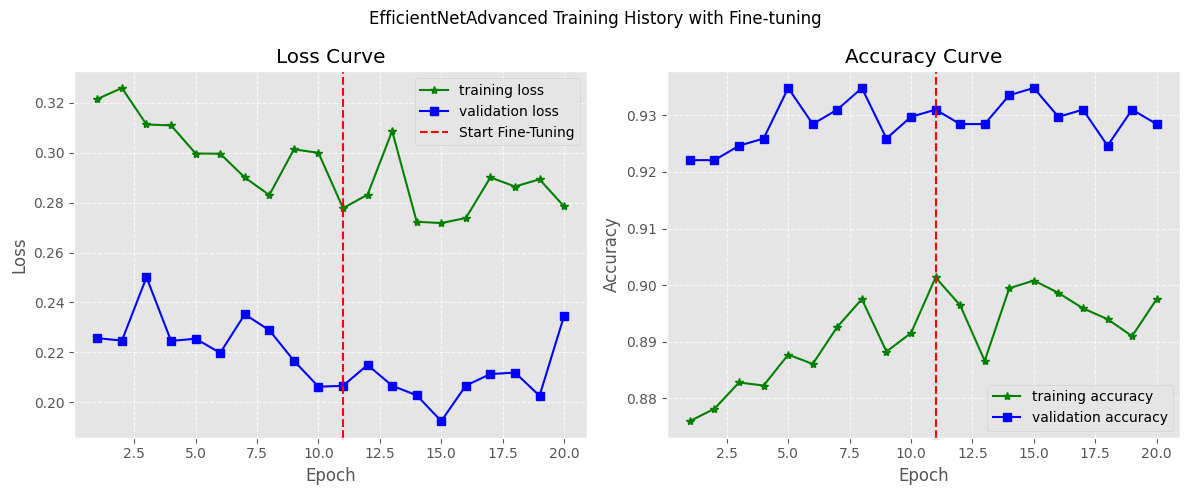

In [72]:
model_saved_name = (
    f"{project_root}/results/{MODEL_NAME}_finetuned"
)
plot_history(
    history,
    f"{MODEL_NAME} Training History with Fine-tuning",
    f"{model_saved_name}.png",
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1,
)

In [73]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 25/25 [00:03<00:00,  7.26it/s]

Accuracy score: 0.9186
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       245
           1       0.90      0.87      0.88       271
           2       0.91      0.91      0.91       270

    accuracy                           0.92       786
   macro avg       0.92      0.92      0.92       786
weighted avg       0.92      0.92      0.92       786



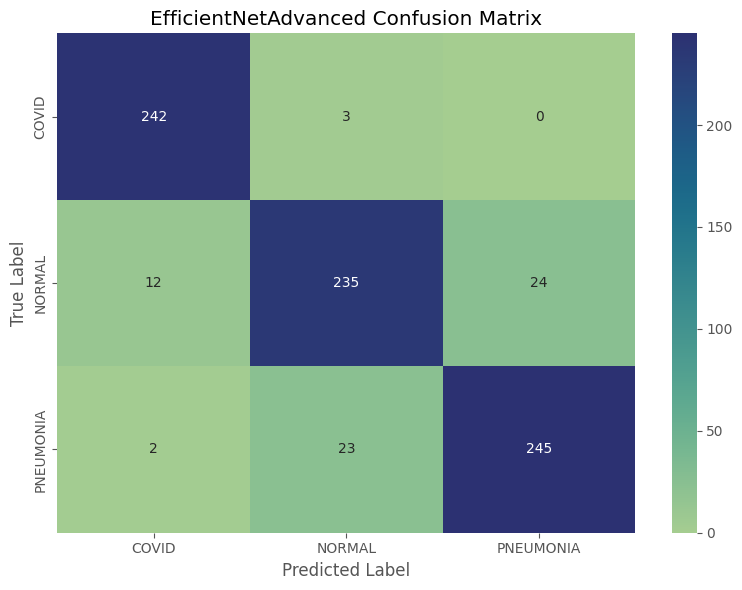

In [74]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_finetuned_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME, class_names=CLASSES, save_path=save_path)

In [75]:
history["MODEL_SAVED_PATH"] = model_save_path
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_finetuned_history.json",
)
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/results/EfficientNetAdvanced_finetuned_history.json


## 5. **Hyperparameter tuning using Ray**

In this section, we will focus on tuning two main things: `batch_size` and `num_unfreezed_layers`

In [76]:
import torch
import ray
from ray import tune
import tempfile
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Checkpoint

In [83]:
train_ref = ray.put(train_dataset)
val_ref = ray.put(val_dataset)

def objective(config):
    batch_size = config["batch_size"]
    num_unfreezed_layers = config["num_unfreezed_layers"]

    train_dataset = ray.get(train_ref)
    val_dataset = ray.get(val_ref)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    model = EfficientAdvanced(len(CLASSES)).to(device=DEVICE)
    # Load the trained head-only model to avoid fine-tuning from scratch
    MODEL_SAVED_PATH = os.path.join(
        project_root, f"model_checkpoints/EfficientNetAdvanced.pth"
    )
    checkpoint = torch.load(MODEL_SAVED_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    params = list(model.parameters())
    for param in params[-num_unfreezed_layers:]:
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(15):
        train_one_epoch(
            model=model, dataloader=train_loader, criterion=criterion, optimizer=optimizer, device=DEVICE
        )  # Train the model
        avg_loss, avg_acc = evaluate(model, val_loader, criterion = criterion, device = DEVICE)  # Compute val accuracy

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            torch.save(model.state_dict(), os.path.join(temp_checkpoint_dir, "model.pth"))
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            tune.report(
                {"loss": avg_loss, "epoch": epoch}, checkpoint=checkpoint
            )  # Report to Tune


search_space = {"batch_size": tune.grid_search([i for i in range(16, 40, 8)]),
                "num_unfreezed_layers": tune.grid_search([30, 90, 150])}


# Add early stopping
asha_scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=5,
)
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
    ),
    param_space=search_space,
)
results = tuner.fit()

(pid=12983) [2025-12-22 17:34:20,676 E 12983 22201167] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
Training:   0%|          | 0/229 [00:00<?, ?it/s]
(pid=13123) [2025-12-22 17:34:21,343 E 13123 22201563] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 8x across cluster]
Evaluating: 100%|██████████| 33/33 [00:14<00:00,  2.35it/s]
(objective pid=13116) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/mac/ray_results/objective_2025-12-22_17-33-38/objective_ad9f9_00001_1_batch_size=24,num_unfreezed_layers=30_2025-12-22_17-33-38/checkpoint_000000)
Evaluating: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]
(

In [84]:
print("Best config is:", results.get_best_result("loss", mode="min"))

Best config is: Result(
  metrics={'loss': 0.15496729185868954, 'epoch': 14},
  path='/Users/mac/ray_results/objective_2025-12-22_17-33-38/objective_ad9f9_00004_4_batch_size=24,num_unfreezed_layers=90_2025-12-22_17-33-38',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/Users/mac/ray_results/objective_2025-12-22_17-33-38/objective_ad9f9_00004_4_batch_size=24,num_unfreezed_layers=90_2025-12-22_17-33-38/checkpoint_000014)
)


In [86]:
best_result = results.get_best_result("loss", mode="min")

with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

In [87]:
model = EfficientAdvanced(len(CLASSES))
model.load_state_dict(state_dict)

<All keys matched successfully>

Getting predictions:   0%|          | 0/25 [00:00<?, ?it/s]/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Getting predictions: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]


Accuracy score: 0.9338
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       245
           1       0.92      0.89      0.91       271
           2       0.93      0.93      0.93       270

    accuracy                           0.93       786
   macro avg       0.93      0.94      0.93       786
weighted avg       0.93      0.93      0.93       786



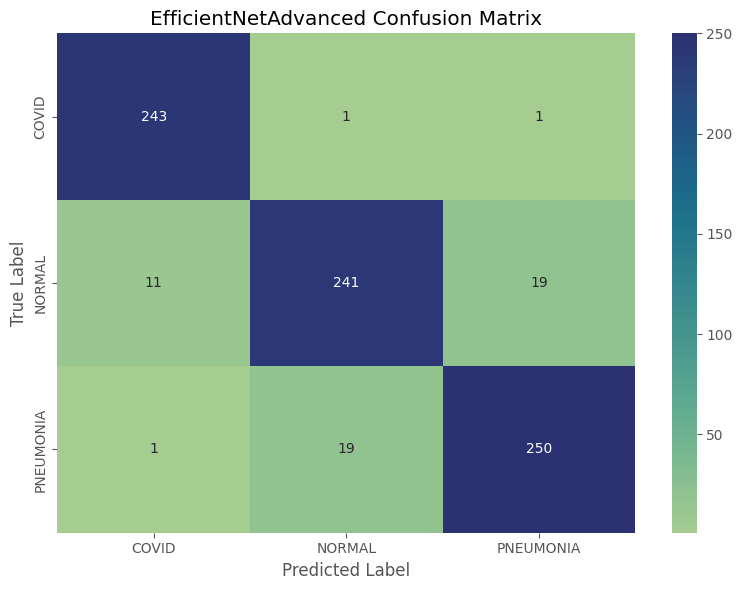

In [88]:
model = model.to(DEVICE)
save_path = (
    f"{project_root}/results/{MODEL_NAME}_finetuned_hyperparameter_tuning_cfm.png"
)
performance(
    model, test_loader, DEVICE, MODEL_NAME, class_names=CLASSES, save_path=save_path
)

In [89]:
# Save in real model weight
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_finetuned_hyperparameter_tuned.pth"
checkpoint = {"state_dict": state_dict}
torch.save(checkpoint, model_save_path)

# **6. Model Evaluation with Grad-Cam**

In [90]:
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_finetuned_hyperparameter_tuned.pth"
model = EfficientAdvanced(len(CLASSES))
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [91]:
# Unfreeze all weights to get Grad-Cam
for param in model.parameters():
    param.requires_grad = True

/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


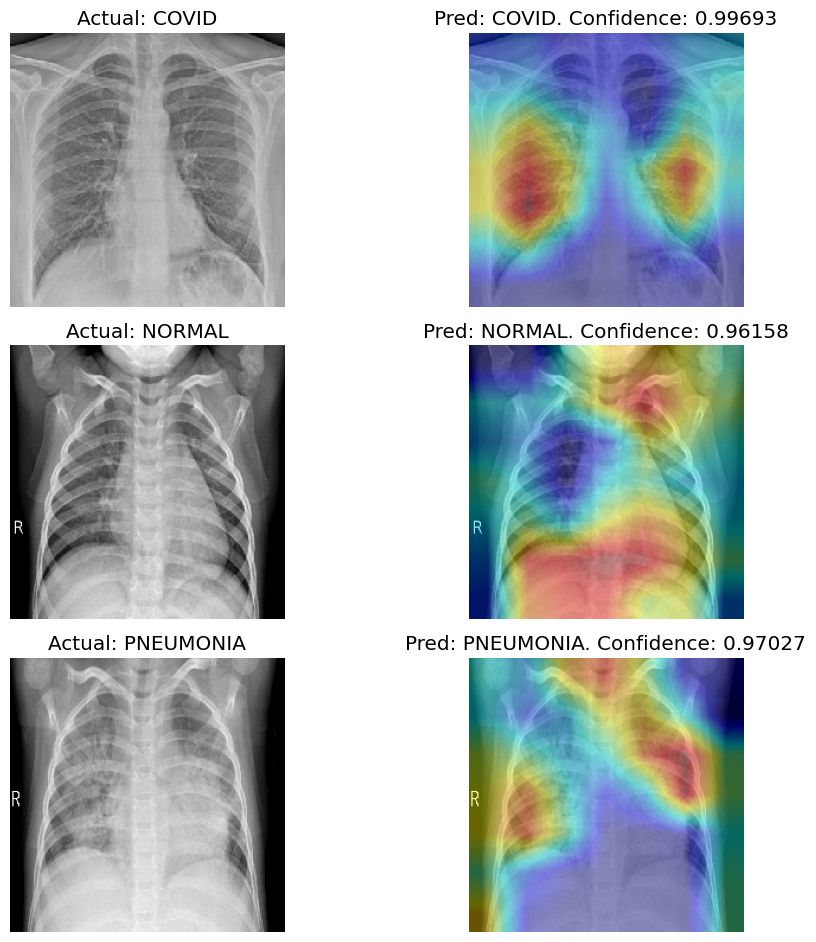

In [92]:
from utils import make_gradcam_heatmap, get_gradcam, get_last_conv_layer
import random
def get_random_image(class_name):
    class_path = os.path.join(f"{project_root}/data/test", class_name)
    images = os.listdir(class_path)
    random.shuffle(images)
    image_path = os.path.join(class_path, images[0])
    return image_path

target_layer = get_last_conv_layer(model)
index = 1
plt.figure(figsize=(12, 10))
for class_name in CLASSES:
    image_path = get_random_image(class_name)
    pil_image = Image.open(image_path)
    original_img = np.array(pil_image)
    transformed_image = eval_transform(pil_image).unsqueeze(0)
    model.eval()
    plt.subplot(len(CLASSES), 2, index)
    plt.imshow(original_img)
    plt.xlabel("Original X-ray Image")
    plt.title(f"Actual: {class_name}")
    plt.axis("off")
    index +=1

    outputs = model(transformed_image)
    probability = torch.softmax(outputs, dim=1)
    prediction = torch.argmax(probability, dim=1).tolist()[0]
    confidence = probability[:, prediction][0]
    heatmap = make_gradcam_heatmap(model, target_layer, transformed_image)

    visualization = get_gradcam(original_img, heatmap)
    plt.subplot(len(CLASSES), 2, index)
    plt.imshow(visualization)
    plt.xlabel("Grad-CAM Heatmap")
    plt.title(f"Pred: {CLASSES[prediction]}. Confidence: {confidence:.5f}")
    plt.tight_layout()
    plt.axis('off')
    index += 1
plt.show()